In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-datasetdog-cat-and-panda


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_path = "/kaggle/input/animal-image-datasetdog-cat-and-panda"
images_path = os.path.join(dataset_path, "images")  # Main images folder

# New train/test directory structure
base_dir = "/kaggle/working/animal_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Organize images into class-based folders (cat, dog, panda)
for class_name in os.listdir(images_path):
    class_path = os.path.join(images_path, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

    # Create class folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy files
    for file in train_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print("✅ Train/Test Split Completed!")


✅ Train/Test Split Completed!


Filtered dataset ready at: /kaggle/working/filtered_animals
Epoch [1/10] Loss: 0.8385, Acc: 56.62%
Epoch [2/10] Loss: 0.7064, Acc: 63.88%
Epoch [3/10] Loss: 0.6195, Acc: 71.08%
Epoch [4/10] Loss: 0.5222, Acc: 75.92%
Epoch [5/10] Loss: 0.4433, Acc: 80.33%
Epoch [6/10] Loss: 0.3640, Acc: 83.92%
Epoch [7/10] Loss: 0.2610, Acc: 89.67%
Epoch [8/10] Loss: 0.1989, Acc: 91.92%
Epoch [9/10] Loss: 0.1386, Acc: 94.71%
Epoch [10/10] Loss: 0.0782, Acc: 97.42%


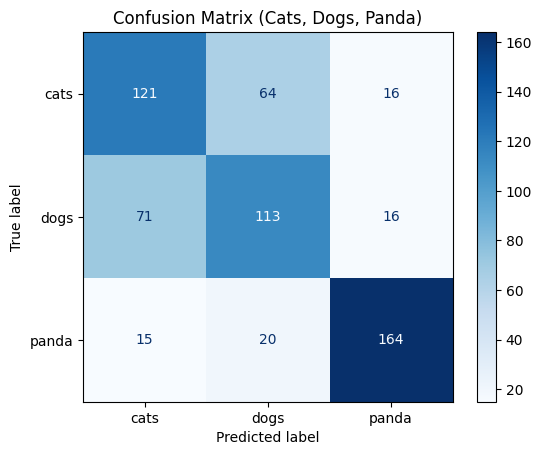

In [11]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ✅ 1. Setup Paths
original_dir = "/kaggle/input/animal-image-datasetdog-cat-and-panda/animals"
filtered_dir = "/kaggle/working/filtered_animals"

# ✅ 2. Create a filtered folder with only cats, dogs, panda
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir, exist_ok=True)
    for cls in ["cats", "dogs", "panda"]:
        src = os.path.join(original_dir, cls)
        dst = os.path.join(filtered_dir, cls)
        shutil.copytree(src, dst)
print("Filtered dataset ready at:", filtered_dir)

# ✅ 3. Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ✅ 4. Load Only Cats, Dogs, Panda
dataset = datasets.ImageFolder(root=filtered_dir, transform=transform)
dataset.classes = ['cats', 'dogs', 'panda']  # Keep order clean

# ✅ 5. Train-test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# ✅ 6. CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(16 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)  # ✅ 3 classes: cats, dogs, panda

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

# ✅ 7. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ 8. Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Acc: {100*correct/total:.2f}%")

# ✅ 9. Confusion Matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cats', 'dogs', 'panda'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Cats, Dogs, Panda)")
plt.show()
